In [1]:
# Problem Statement: Predict whether a patient has diabetes based on several diagnostic measurements.
# Objective: Develop a binary classification model to accurately predict diabetes presence and evaluate the model's performance using various metrics.
# Features: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age
# Target: Outcome (1 for diabetes, 0 for no diabetes)

In [2]:
import pickle
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE

## 1. Select a Dataset

In [4]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

# Display the first few rows of the dataframe
print(df.head())

# Display summary statistics and information about the dataset
print(df.describe())
print(df.info())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

## 2. Data Exploration

In [6]:
# Summary Statistics
summary_stats = df.describe().T
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
                           count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.

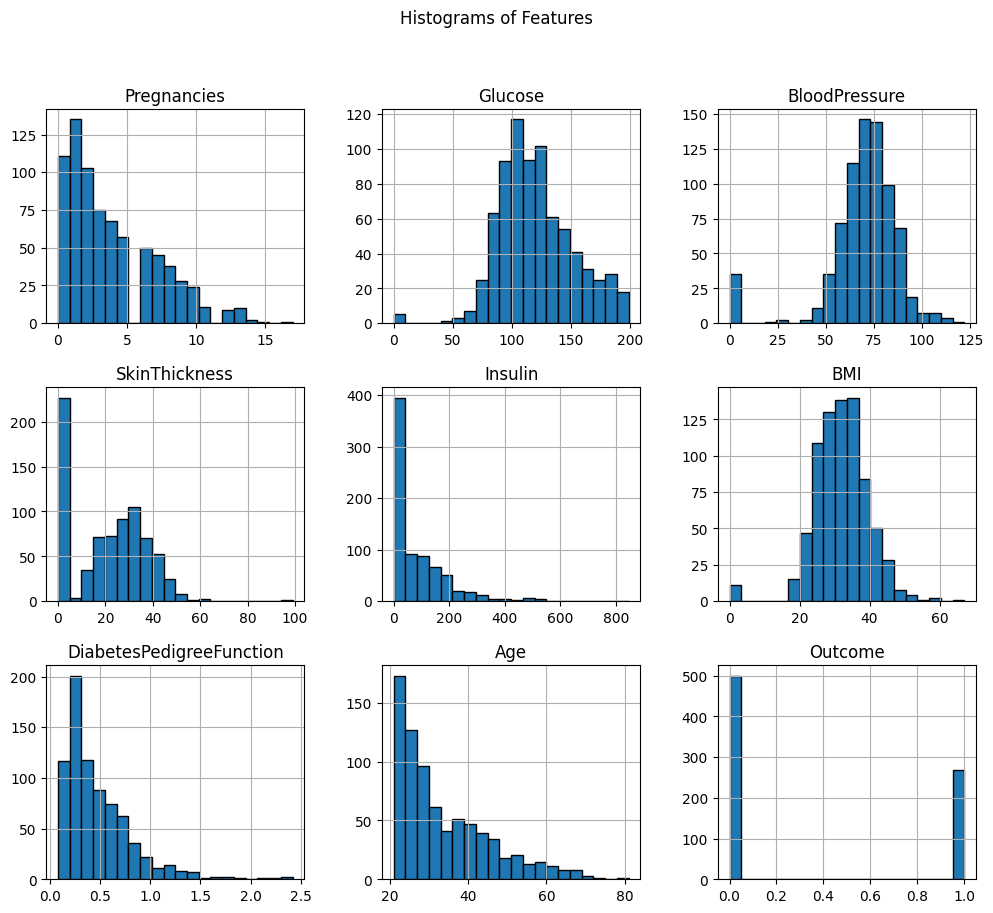

In [7]:
# Distribution of Features
# Histograms
df.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Histograms of Features')
plt.show()

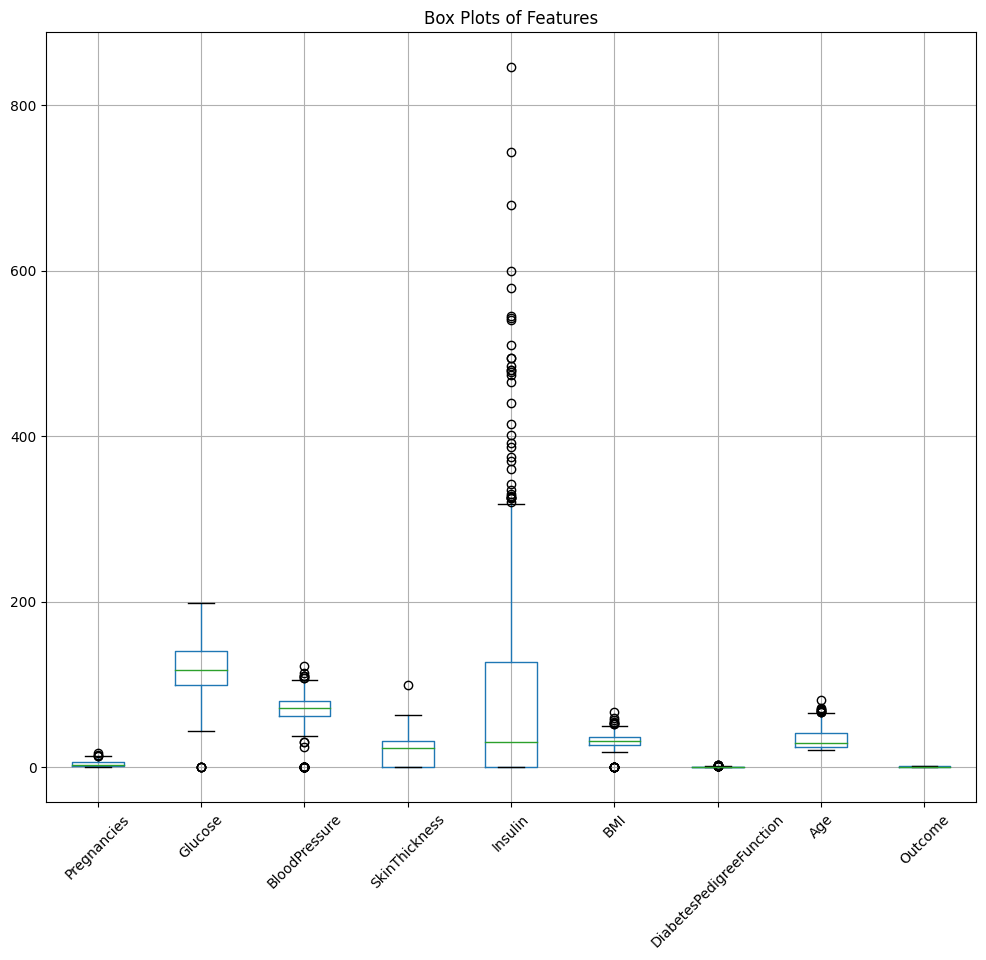

In [8]:
# Box Plots
plt.figure(figsize=(12, 10))
df.boxplot()
plt.title('Box Plots of Features')
plt.xticks(rotation=45)
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_20884\1414546998.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[column], shade=True, label=column)
C:\Users\milto\AppData\Local\Temp\ipykernel_20884\1414546998.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[column], shade=True, label=column)
C:\Users\milto\AppData\Local\Temp\ipykernel_20884\1414546998.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[column], shade=True, label=column)
C:\Users\milto\AppData\Local\Temp\ipykernel_20884\1414546998.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an erro

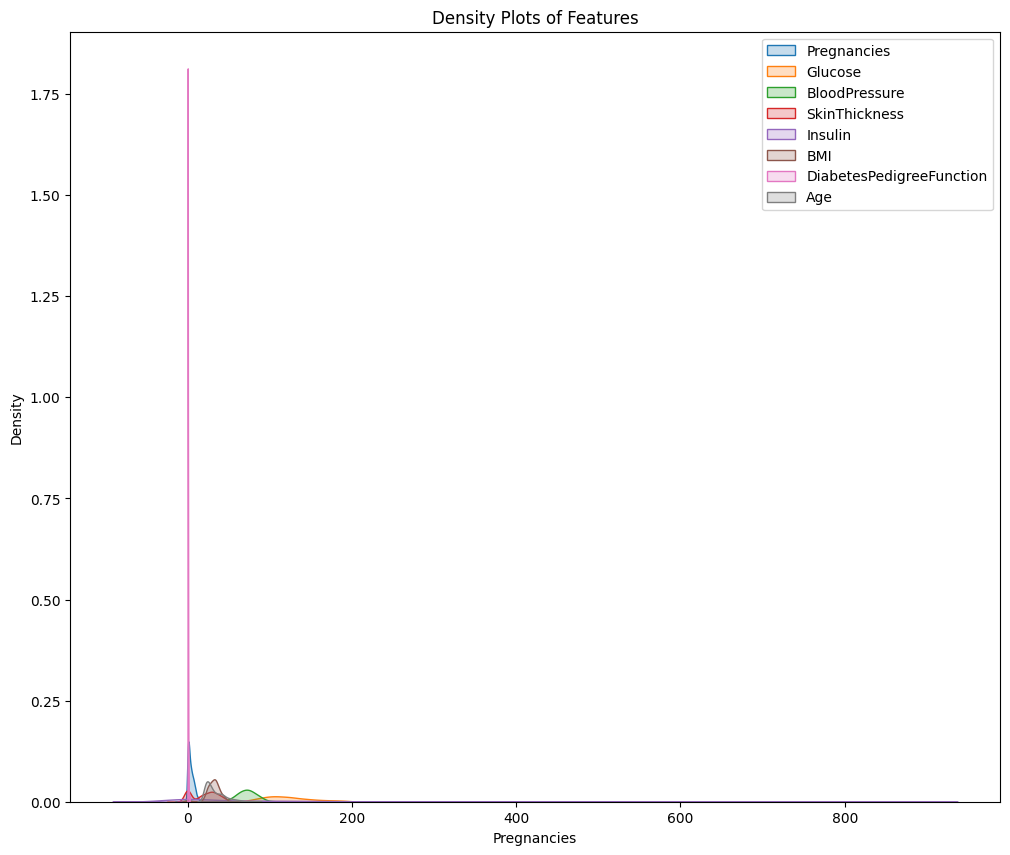

In [9]:
# Density Plots
plt.figure(figsize=(12, 10))
# Exclude the target column 'Outcome'
for column in df.columns[:-1]:  
    sns.kdeplot(df[column], shade=True, label=column)
plt.title('Density Plots of Features')
plt.legend()
plt.show()

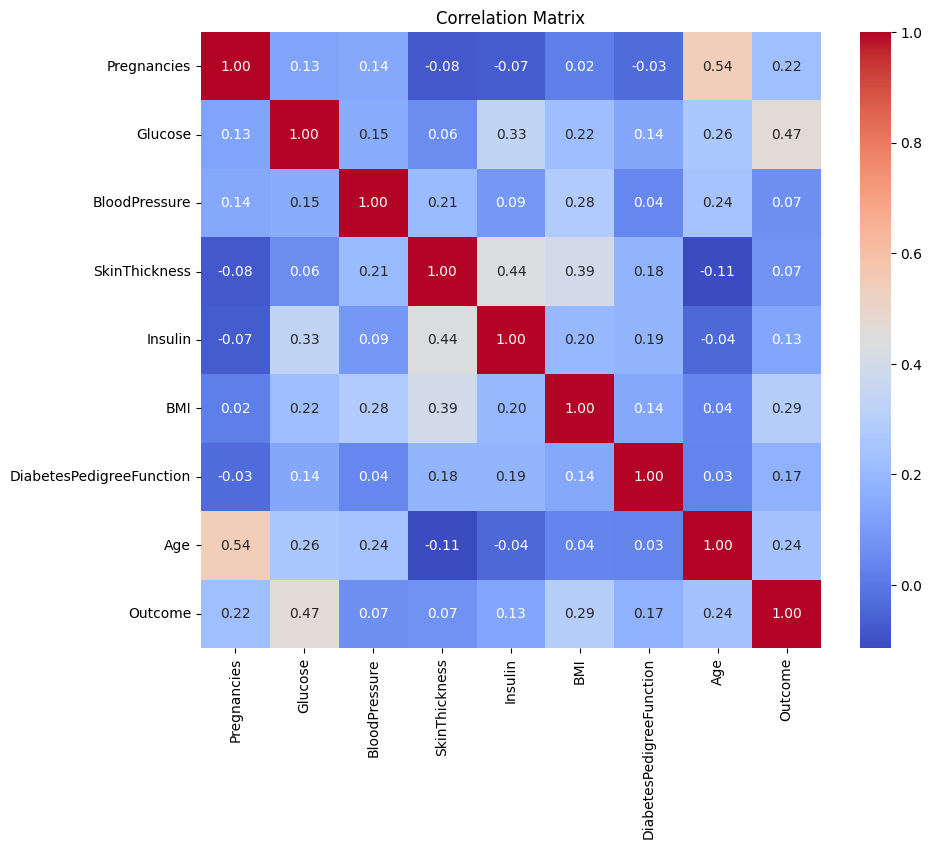

In [10]:
# Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

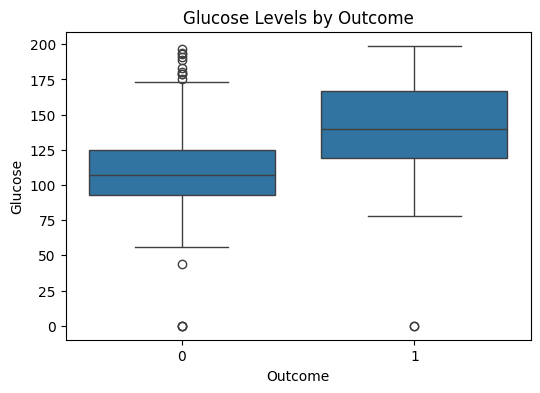

In [11]:
# Plot relationships between Glucose vs. Outcome
plt.figure(figsize=(6, 4))
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose Levels by Outcome')
plt.show()

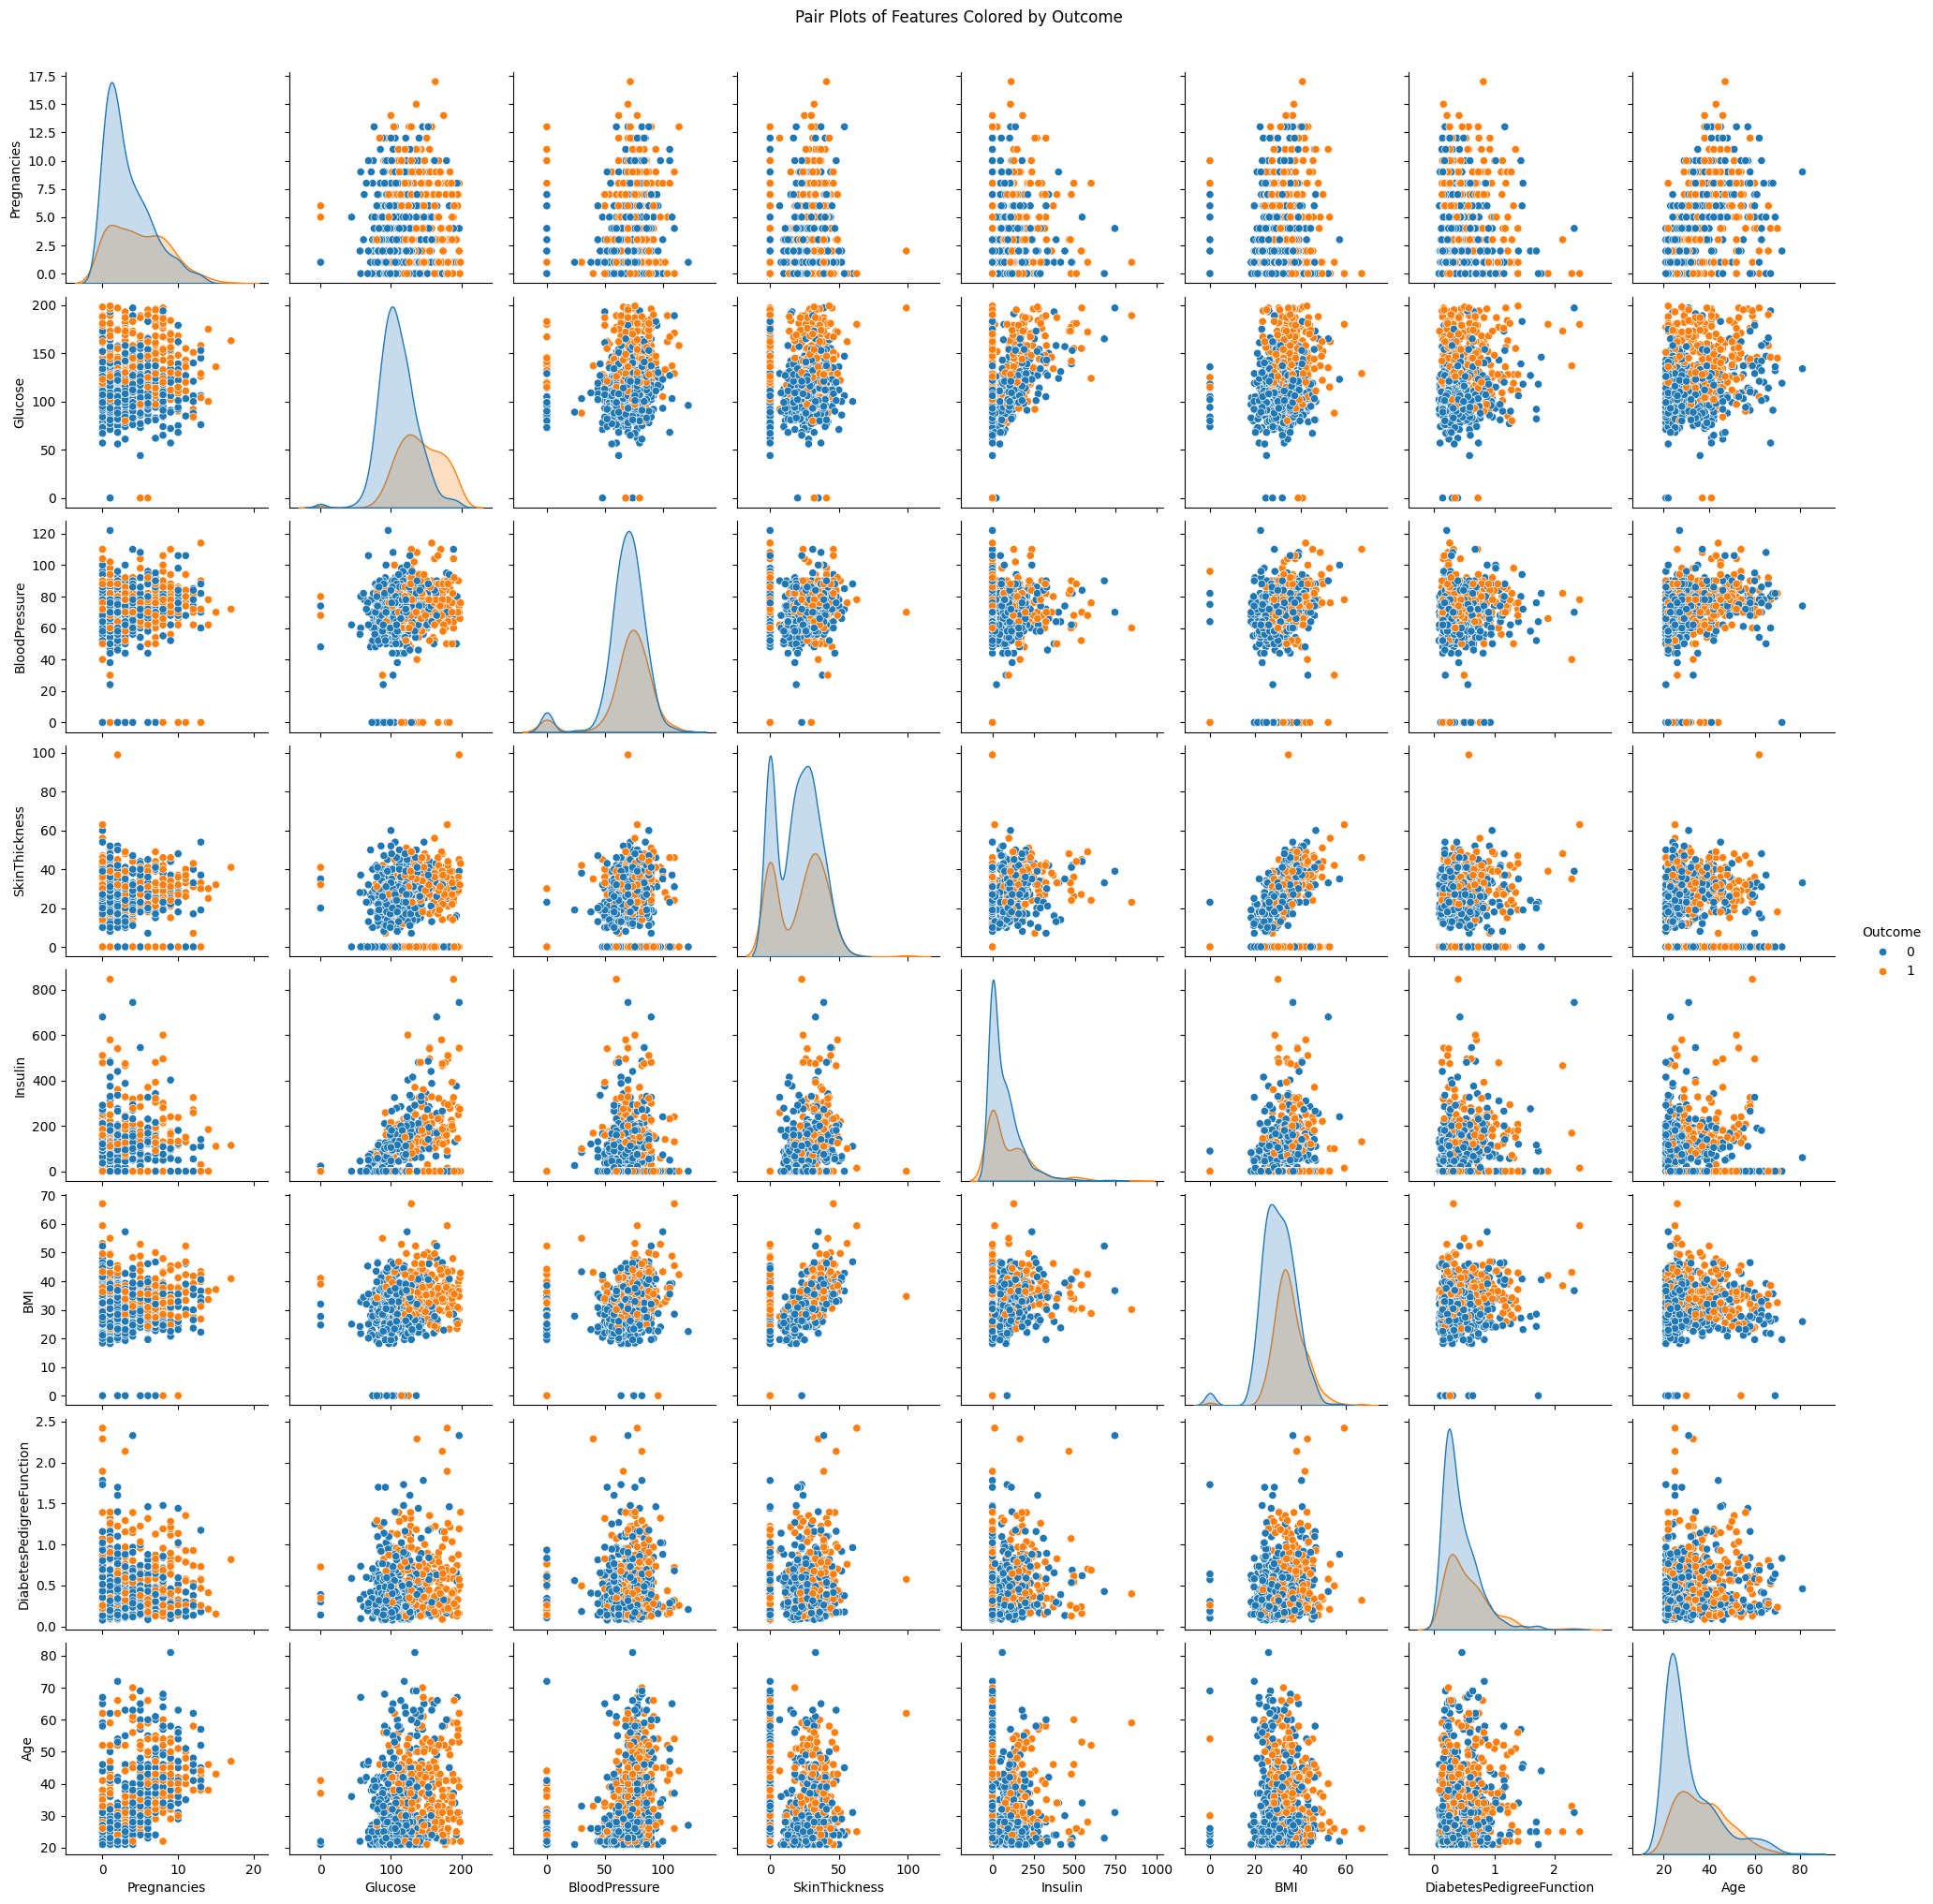

In [12]:
# Pairwise Relationships
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.suptitle('Pair Plots of Features Colored by Outcome', y=1.02)
plt.show()

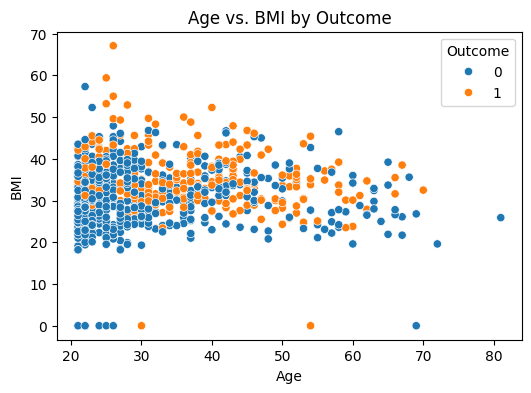

In [13]:
# Scatter Plots and Pair Plots of Age vs. BMI
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Age', y='BMI', hue='Outcome', data=df)
plt.title('Age vs. BMI by Outcome')
plt.show()

## 3. Data Preprocessing 

In [16]:
# Check for Missing Values
missing_values = df.isnull().sum()
print("Missing Values in Each Feature:\n", missing_values)

Missing Values in Each Feature:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [17]:
# Separating features and target variable
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling imbalanced data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert scaled training data back to a DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Using the original DataFrame to compute the correlation with the target
full_df = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)
correlation_matrix = full_df.corr()

# Specify a correlation threshold
correlation_threshold = 0.1  

# Select features with a correlation above the threshold with the target variable
selected_features = correlation_matrix.index[abs(correlation_matrix['Outcome']) > correlation_threshold].tolist()
 # Remove the target variable from the feature list
selected_features.remove('Outcome') 

# Display selected features
print("Selected features based on correlation threshold:", selected_features)

Selected features based on correlation threshold: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


## 4. Model Selection

In [19]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train_resampled)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluation
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("ROC AUC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]))
print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression
Accuracy: 0.6948051948051948
ROC AUC Score: 0.8137741046831956
              precision    recall  f1-score   support

           0       0.81      0.69      0.74        99
           1       0.56      0.71      0.62        55

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.72      0.69      0.70       154

[[68 31]
 [16 39]]


In [20]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("\nRandom Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Classifier
Accuracy: 0.7207792207792207
ROC AUC Score: 0.8120293847566575
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154

[[77 22]
 [21 34]]


In [21]:
# Support Vector Machine
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train_resampled)  # Use the resampled target variable
y_pred_svm = svm.predict(X_test_scaled)

# Evaluation
print("\nSupport Vector Machine")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC AUC Score:", roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:, 1]))
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


Support Vector Machine
Accuracy: 0.7142857142857143
ROC AUC Score: 0.796694214876033
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        99
           1       0.59      0.67      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154

[[73 26]
 [18 37]]


## 5. Model Training 

In [23]:
# Hyperparameter Tuning with GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l2', None],  # Adjusted for compatibility
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_scaled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.23357214690901212}


## 6. Model Evaluation

In [25]:
# Initialize the best model using the best parameters
best_logreg = LogisticRegression(**best_params, random_state=42)

# Train the best model on the training data
best_logreg.fit(X_train_scaled, y_train_resampled)

LogisticRegression(C=0.23357214690901212, max_iter=1000, random_state=42,
                   solver='newton-cg')

In [26]:
# Predict on the test data
y_pred_best_logreg = best_logreg.predict(X_test_scaled)
y_pred_proba_best_logreg = best_logreg.predict_proba(X_test_scaled)[:, 1]

In [27]:
# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_best_logreg)
precision = precision_score(y_test, y_pred_best_logreg)
recall = recall_score(y_test, y_pred_best_logreg)
f1 = f1_score(y_test, y_pred_best_logreg)
roc_auc = roc_auc_score(y_test, y_pred_proba_best_logreg)

print(f"Best Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Best Logistic Regression Model Performance:
Accuracy: 0.6948
Precision: 0.5571
Recall: 0.7091
F1 Score: 0.6240
ROC AUC Score: 0.8145


## 7. Model Deployment

In [29]:
# Save the Model

# Save the trained model to a file using pickle
with open('best_logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(best_logreg, file)

print("Model saved to 'best_logistic_regression_model.pkl'")

Model saved to 'best_logistic_regression_model.pkl'


In [30]:
# Demonstrate Prediction

# Example of new data
new_data = {
    'Pregnancies': [2],
    'Glucose': [138],
    'BloodPressure': [62],
    'SkinThickness': [35],
    'Insulin': [0],
    'BMI': [33.6],
    'DiabetesPedigreeFunction': [0.127],
    'Age': [47]
}

# Convert dictionary to DataFrame
new_df = pd.DataFrame(new_data)

# Apply scaling on the new data
new_df_scaled = scaler.transform(new_df)

# Make a prediction
prediction = best_logreg.predict(new_df_scaled)
prediction_proba = best_logreg.predict_proba(new_df_scaled)[:, 1]

# Output the prediction and probability
print("Predicted Class:", prediction[0])
print("Probability of Being Positive Class:", prediction_proba[0])

Predicted Class: 1
Probability of Being Positive Class: 0.6996054675061683


## 8. Report and Interpretation

In [32]:
# Interpretation

# A woman in this example:
# Pregnancies: 2
# Glucose: 138
# BloodPressure: 62
# SkinThickness: 35 mm
# Insulin: 0
# BMI: 33.6
# DiabetesPedigreeFunction: 0.127
# Age: 47

# Predicted Class: 1
# This meaning the model predicts this individual has diabetes
# Probability: About 69.96%